<a href="https://colab.research.google.com/github/vujjiniashrith/IOT_security/blob/main/Generative_Adversarial_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the dataset and preprocessing it

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

***import the entire dataset and remove the nan values***

In [ ]:
df = pd.read_excel("combined_dataset.xlsx")

In [ ]:
columns = df.columns
print(columns)
columns_to_delete = [ 'INOP_PLETH','INOP_SpO2', 'INOP_RESP', 'INOP_NOISE', 'ALARM']
df.drop(columns=columns_to_delete, inplace=True)
print(df.columns)

Index(['SpO2', 'HR', 'PULSE', 'RESP', 'ABP1', 'ABP2', 'ABP3', 'INOP_PLETH',
       'INOP_SpO2', 'INOP_RESP', 'INOP_NOISE', 'ALARM'],
      dtype='object')
Index(['SpO2', 'HR', 'PULSE', 'RESP', 'ABP1', 'ABP2', 'ABP3'], dtype='object')


In [ ]:
df.shape

(87879, 7)

<AxesSubplot:>

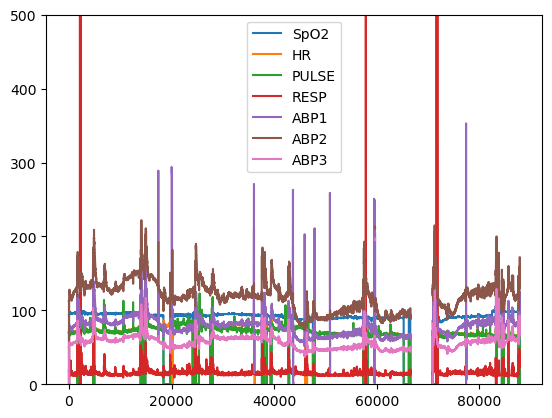

In [ ]:
df.plot(ylim=(0, 500), kind='line')

<AxesSubplot:>

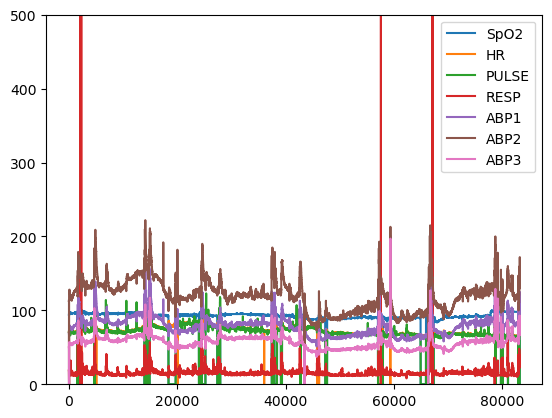

In [ ]:
df.dropna( inplace = True)
df.reset_index(drop = True, inplace = True)
df.plot(ylim=(0, 500), kind='line')

<AxesSubplot:>

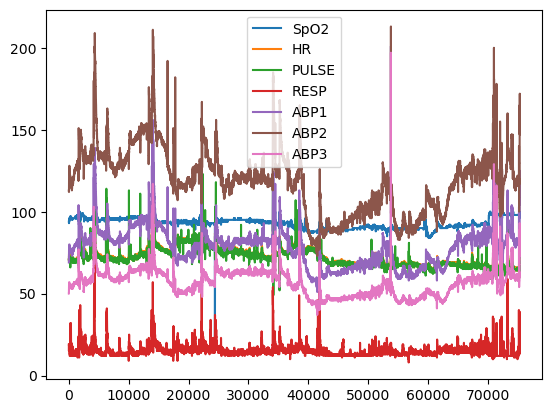

In [ ]:
df = df.loc[(df != 0).all(axis=1)]
df.reset_index(drop = True, inplace = True)
df.plot(kind='line')

***Split the dataset into train and test and normalize***

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
data = df.values

In [ ]:
print(data.shape)
print(len(data)*0.8)

(75380, 7)
60304.0


In [ ]:
train = data[:60304]
test = data[60304:]

In [ ]:
scaler_train = StandardScaler()
scaler_test = StandardScaler()

In [ ]:
train = scaler_train.fit_transform(train)
test = scaler_test.fit_transform(test)

In [ ]:
lookback = 128
reshaped_train = []
reshaped_test= []

for i in range(len(train)-lookback+1):
    sample_train = train[i:i+lookback]
    reshaped_train.append(sample_train)
reshaped_train = np.array(reshaped_train)


for i in range(len(test)-lookback+1):
    sample_test = test[i:i+lookback]
    reshaped_test.append(sample_test)
reshaped_test = np.array(reshaped_test)

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices(reshaped_train)

In [ ]:
train_data = train_data.cache()

In [ ]:
train_data = train_data.batch(128)

In [ ]:
dataiterator = train_data.as_numpy_iterator()

In [ ]:
dataiterator.next().shape

(128, 128, 7)

# Build Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten , Reshape, LeakyReLU, Dropout, UpSampling1D,Conv2D

***Generator***

In [ ]:
def build_generator():
    model = Sequential()

    #we give 64 random inputs to generate a sequence of (128,7) output
    model.add(Dense(16*7, input_dim = 16))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((16,7)))

    #Upsampling block 1
    model.add(UpSampling1D())#effectively doubles the each row and column
    model.add(Conv1D(14,5,padding = 'same'))# total 128 filters with shape 5x5
    model.add(LeakyReLU(0.2))

    #Upsampling block 2
    model.add(UpSampling1D())
    model.add(Conv1D(28,5,padding='same'))
    model.add(LeakyReLU(0.2))

    #Upsampling block 3
    model.add(UpSampling1D())#effectively doubles the each row and column
    model.add(Conv1D(14,5,padding = 'same'))# total 128 filters with shape 5x5
    model.add(LeakyReLU(0.2))

    #Convlutional bloc 1
    model.add(Conv1D(7,4,padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Conv1D(7,4,padding = 'same', activation = 'sigmoid'))

    return model

In [ ]:
generator = build_generator()

In [ ]:
generator.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 112)               1904      
                                                                 
 leaky_re_lu_55 (LeakyReLU)  (None, 112)               0         
                                                                 
 reshape_19 (Reshape)        (None, 16, 7)             0         
                                                                 
 up_sampling1d_29 (UpSamplin  (None, 32, 7)            0         
 g1D)                                                            
                                                                 
 conv1d_42 (Conv1D)          (None, 32, 14)            504       
                                                                 
 leaky_re_lu_56 (LeakyReLU)  (None, 32, 14)            0         
                                                     

In [ ]:
imgs = generator.predict(np.random.randn(4,16))

In [ ]:
imgs.shape

(4, 128, 7)

***Build Discriminator***

In [ ]:
def build_discriminator():
    model = Sequential()

    #first conv block
    model.add(Conv1D(28,5,2,input_shape = (128,7)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Conv1D(56,5,2,input_shape = (128,7)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Conv1D(75,5,2,input_shape = (128,7)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))


    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1,activation = 'sigmoid'))



    return model

In [ ]:
discriminator = build_discriminator()

In [ ]:
discriminator.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_62 (Conv1D)          (None, 62, 28)            1008      
                                                                 
 leaky_re_lu_77 (LeakyReLU)  (None, 62, 28)            0         
                                                                 
 dropout_17 (Dropout)        (None, 62, 28)            0         
                                                                 
 conv1d_63 (Conv1D)          (None, 29, 56)            7896      
                                                                 
 leaky_re_lu_78 (LeakyReLU)  (None, 29, 56)            0         
                                                                 
 dropout_18 (Dropout)        (None, 29, 56)            0         
                                                                 
 conv1d_64 (Conv1D)          (None, 13, 75)          

In [ ]:
discriminator.predict(imgs)

array([[0.5234254 ],
       [0.5235138 ],
       [0.52437705],
       [0.5235823 ]], dtype=float32)

# Building Custom Training Loop

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
g_opt = Adam(learning_rate = 0.0001)
d_opt = Adam(learning_rate = 0.00001)

In [ ]:
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

***Build Subclassed Model***

In [ ]:
from tensorflow.keras.models import Model

In [ ]:
class WBAN_GAN(Model):
    def __init__(self, generator,discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)

        #create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        #compile with the base class
        super().compile(*args, **kwargs)

        #create attribute for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss


    def train_step(self,batch):

        #get the data
        real_data = batch
        fake_data = self.generator(tf.random.normal((128,16,1)), training = False)

        #train the dicriminator
        with tf.GradientTape() as d_tape:
            #pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_data , training = True)
            yhat_fake = self.discriminator(fake_data, training = True)
            yhat_realfake = tf.concat([yhat_real,yhat_fake],axis = 0)

            #Create labels for real and fake images
            y_realfake = tf.concat([tf.zeros_like(yhat_real),tf.ones_like(yhat_fake)],axis=0)

            #add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real,noise_fake],axis=0)

            #calculate loss
            total_d_loss = self.d_loss(y_realfake,yhat_realfake)

        #Apply backpropogation - nn learn
        dgrad = d_tape.gradient(total_d_loss,self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad,self.discriminator.trainable_variables))


        #train the generator
        with tf.GradientTape() as g_tape:
            #Generate some new images
            gen_data = self.generator(tf.random.normal((128,16,1)), training = True)

            #Create the predicted labels
            predicted_labels = self.discriminator(gen_data,training = False)

            #calculate loss
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels),predicted_labels)

        #apply backpropogation
        ggrad = g_tape.gradient(total_g_loss,self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad,self.generator.trainable_variables))

        return {"d_loss" : total_d_loss, "g_loss": total_g_loss}


In [ ]:
wbanGAN = WBAN_GAN(generator,discriminator)

In [ ]:
wbanGAN.compile(g_opt,d_opt,g_loss,d_loss)

In [ ]:
hist =wbanGAN.fit(train_data,epochs= 20)

Epoch 1/20
471/471 [==============================] - 30s 61ms/step - d_loss: 0.6627 - g_loss: 0.7062
Epoch 2/20
471/471 [==============================] - 29s 61ms/step - d_loss: 0.6515 - g_loss: 0.6861
Epoch 3/20
471/471 [==============================] - 35s 75ms/step - d_loss: 0.6035 - g_loss: 0.7522
Epoch 4/20
471/471 [==============================] - 33s 69ms/step - d_loss: 0.5869 - g_loss: 0.6615
Epoch 5/20
471/471 [==============================] - 34s 72ms/step - d_loss: 0.6262 - g_loss: 0.7595
Epoch 6/20
471/471 [==============================] - 34s 72ms/step - d_loss: 0.5995 - g_loss: 0.7885
Epoch 7/20
471/471 [==============================] - 34s 72ms/step - d_loss: 0.5796 - g_loss: 0.7705
Epoch 8/20
471/471 [==============================] - 34s 72ms/step - d_loss: 0.5449 - g_loss: 0.8901
Epoch 9/20
471/471 [==============================] - 34s 73ms/step - d_loss: 0.5062 - g_loss: 1.0227
Epoch 10/20
471/471 [==============================] - 34s 73ms/step - d_loss: 0.5

In [ ]:
generator.save_weights('generator1.h5')

In [ ]:
discriminator.save_weights('dicriminator1.h5')